Step 1: Loading and exploring data...
=== Dataset Overview ===
Dataset shape: (19611, 79)
Memory usage: 13.28 MB

No missing values found!

Malware distribution:
Benign (0): 5012 (25.6%)
Malware (1): 14599 (74.4%)

Dataset Statistics:
Total samples: 19,611
Total features: 79
Numeric features: 78

Step 2: Preprocessing data...

=== Data Preprocessing ===
Selected 77 numeric features for analysis
Removing 8 zero-variance features
Removing 3 highly correlated features (correlation > 0.95)
Final feature set: 66 features
Scaling method: robust
Data preprocessing completed!

Step 3: Fitting One Class SVM...
Note: Set auto_tune=False in the next line for faster execution with default parameters

=== Fitting One Class SVM ===
Skipping hyperparameter tuning (auto_tune=False)
Training One Class SVM with parameters:
  nu: 0.1
  kernel: rbf
  gamma: scale
Model fitting completed!
Anomalies detected: 1,925 out of 19,611 samples (9.8%)
Support vectors: 1,962 (10.0%)
Decision score range: [-1834.421,

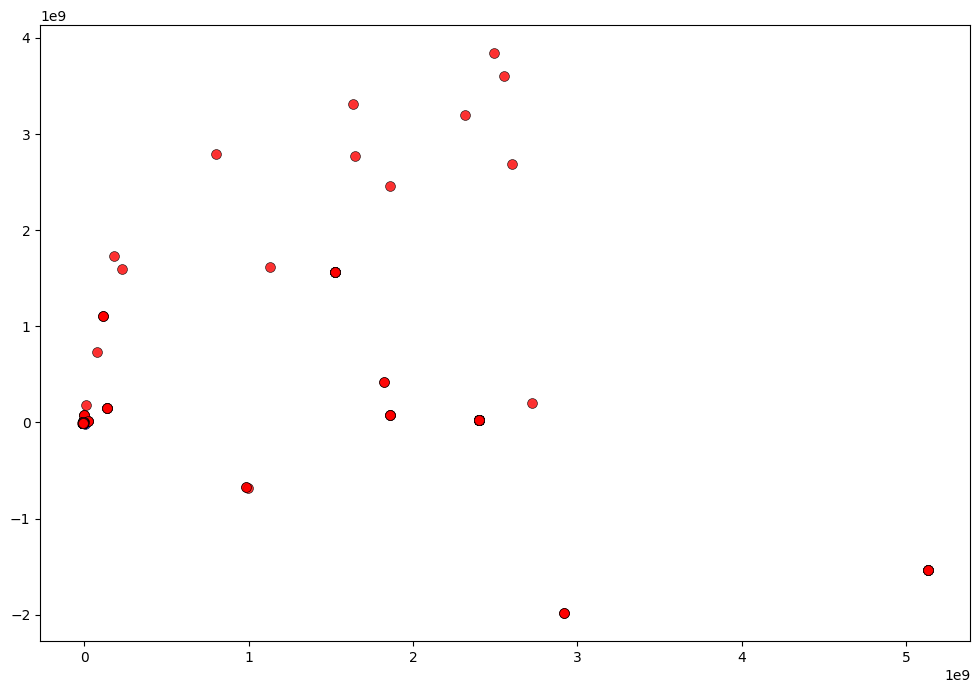

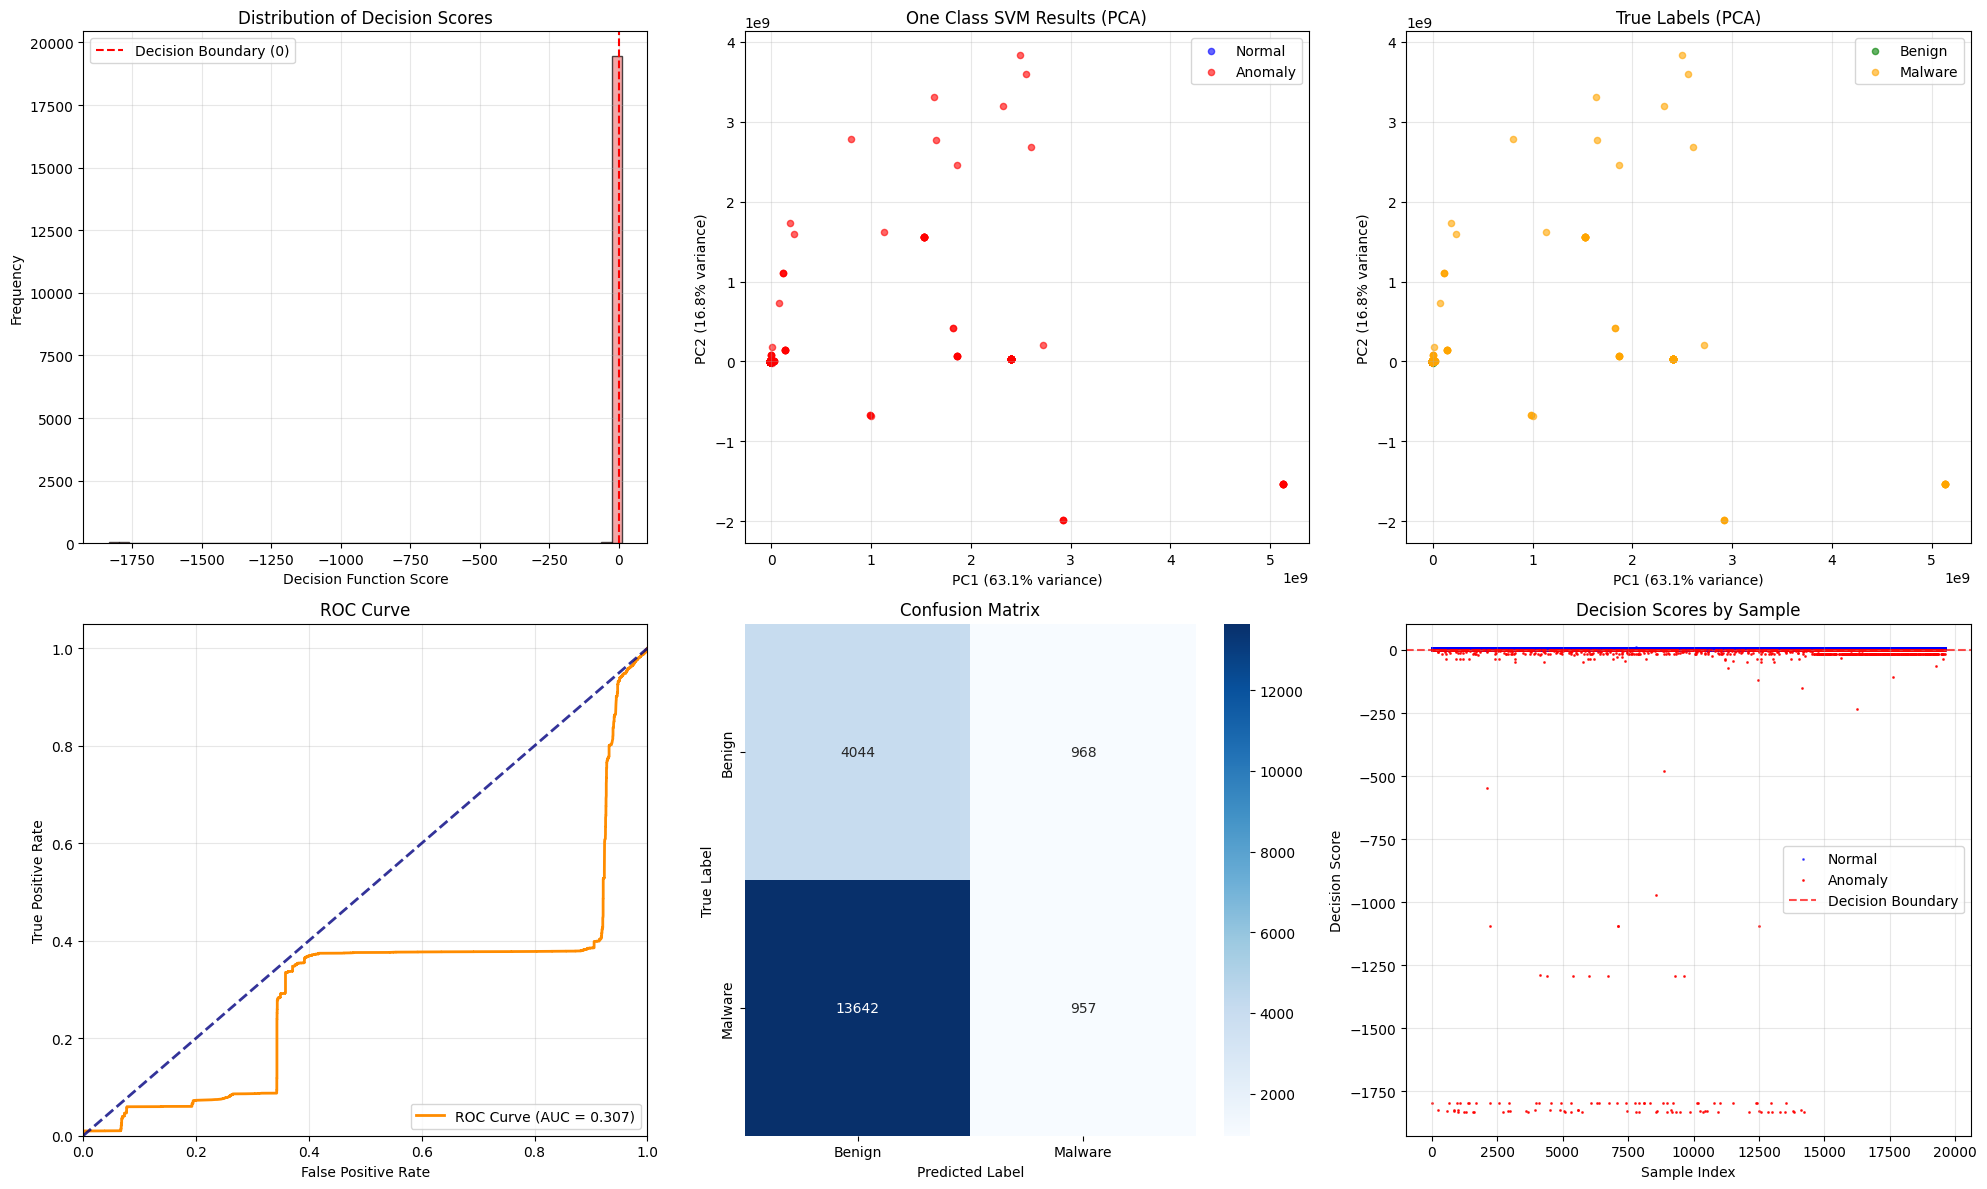


Step 7: Analyzing feature importance...

=== Feature Importance Analysis ===
Top 15 features most correlated with decision scores:
Rank                        Feature   |Correlation|   Raw Corr
-----------------------------------------------------------------
   1                NumberOfSymbols          0.8397    -0.8397
   2           PointerToSymbolTable          0.7316    -0.7316
   3                         e_ovno          0.5777    -0.5777
   4                       e_lfarlc          0.5364    -0.5364
   5                           e_ip          0.4437    -0.4437
   6                           e_cs          0.3635    -0.3635
   7                    LoaderFlags          0.3383    -0.3383
   8    MajorOperatingSystemVersion          0.2941    -0.2941
   9   ImageDirectoryEntryException          0.2919    -0.2919
  10          SuspiciousNameSection          0.2890    -0.2890
  11    MinorOperatingSystemVersion          0.2757    -0.2757
  12                     SizeOfCode          0

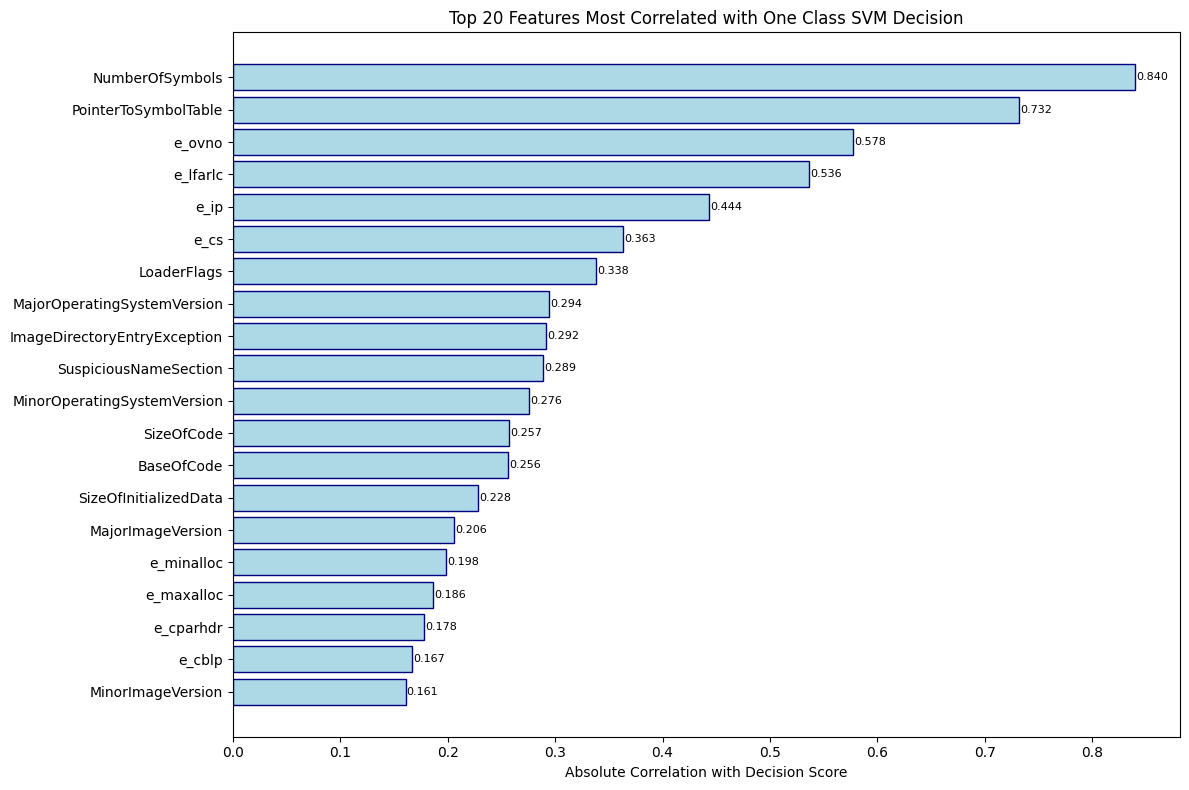


Step 8: Identifying top anomalies...

=== Top 15 Anomalies Analysis ===
Top 15 most anomalous samples:
Rank    Index  Decision Score   True Label                                        Sample Name
-----------------------------------------------------------------------------------------------
   1    13478      -1834.4210      Malware        VirusShare_ef8955e2189733671ff2152840d6f050
   2     7903      -1834.4210      Malware        VirusShare_fc654de367c2d7bc023c8c6ecdf8c2b4
   3    12579      -1834.4210      Malware        VirusShare_efd80c835261d490d931dcd1be33c4a7
   4     5718      -1834.4210      Malware        VirusShare_ef98d285d602b89a2e78ab54b92e325e
   5     9473      -1834.4210      Malware        VirusShare_ef68e8fcd9fcc4efb630d14691470356
   6     3688      -1834.4210      Malware        VirusShare_e646bc21b2545e7abedea85010534af0
   7    13837      -1834.4210      Malware        VirusShare_ef94c39f1f2803730de6b6ace7c304c0
   8     1292      -1834.4210      Malware      

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

class MalwareOneClassSVMAnalyzer:
    def __init__(self, csv_file_path):
        """Initialize the analyzer with the dataset"""
        self.df = pd.read_csv(csv_file_path)
        self.scaler = None
        self.one_class_svm = None
        self.pca_model = None
        self.X_scaled = None
        self.X_pca = None
        self.anomaly_scores = None
        self.anomaly_predictions = None
        self.best_params = None
        
    def load_and_explore_data(self):
        """Load and explore the dataset"""
        print("=== Dataset Overview ===")
        print(f"Dataset shape: {self.df.shape}")
        print(f"Memory usage: {self.df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        # Check for missing values
        missing_vals = self.df.isnull().sum()
        if missing_vals.sum() > 0:
            print(f"\nMissing values found:")
            print(missing_vals[missing_vals > 0])
        else:
            print("\nNo missing values found!")
            
        # Target distribution
        if 'Malware' in self.df.columns:
            malware_dist = self.df['Malware'].value_counts()
            print(f"\nMalware distribution:")
            print(f"Benign (0): {malware_dist.get(0, 0)} ({malware_dist.get(0, 0)/len(self.df)*100:.1f}%)")
            print(f"Malware (1): {malware_dist.get(1, 0)} ({malware_dist.get(1, 0)/len(self.df)*100:.1f}%)")
            
        # Basic statistics
        print(f"\nDataset Statistics:")
        print(f"Total samples: {len(self.df):,}")
        print(f"Total features: {len(self.df.columns)}")
        print(f"Numeric features: {len(self.df.select_dtypes(include=[np.number]).columns)}")
        
        return self.df.head()
    
    def preprocess_data(self, scaler_type='robust'):
        """Preprocess the data for One Class SVM"""
        print("\n=== Data Preprocessing ===")
        
        # Separate features from target and identifier
        exclude_cols = ['Name', 'Malware'] if 'Name' in self.df.columns else ['Malware']
        if 'Malware' in self.df.columns:
            self.y_true = self.df['Malware'].values
        
        # Select numeric features only
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        feature_cols = [col for col in numeric_cols if col not in exclude_cols]
        
        self.X = self.df[feature_cols].copy()
        self.feature_names = feature_cols
        print(f"Selected {len(feature_cols)} numeric features for analysis")
        
        # Handle any remaining missing values
        self.X = self.X.fillna(self.X.median())
        
        # Remove features with zero variance
        zero_var_cols = self.X.columns[self.X.var() == 0]
        if len(zero_var_cols) > 0:
            print(f"Removing {len(zero_var_cols)} zero-variance features")
            self.X = self.X.drop(columns=zero_var_cols)
            self.feature_names = [col for col in self.feature_names if col not in zero_var_cols]
        
        # Remove highly correlated features to improve SVM performance
        correlation_matrix = self.X.corr().abs()
        upper_triangle = correlation_matrix.where(
            np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
        )
        
        # Find features with correlation > 0.95
        high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
        if len(high_corr_features) > 0:
            print(f"Removing {len(high_corr_features)} highly correlated features (correlation > 0.95)")
            self.X = self.X.drop(columns=high_corr_features)
            self.feature_names = [col for col in self.feature_names if col not in high_corr_features]
        
        # Scale the features
        if scaler_type == 'robust':
            self.scaler = RobustScaler()
        elif scaler_type == 'standard':
            self.scaler = StandardScaler()
        elif scaler_type == 'minmax':
            self.scaler = MinMaxScaler()
        else:
            raise ValueError("scaler_type must be 'robust', 'standard', or 'minmax'")
        
        self.X_scaled = self.scaler.fit_transform(self.X)
        
        print(f"Final feature set: {self.X_scaled.shape[1]} features")
        print(f"Scaling method: {scaler_type}")
        print("Data preprocessing completed!")
        return self.X_scaled
    
    def tune_one_class_svm(self, sample_size=2000):
        """Tune One Class SVM hyperparameters with efficient parameter grid"""
        print(f"\n=== Tuning One Class SVM Hyperparameters ===")
        
        # Use smaller sample for faster tuning
        if len(self.X_scaled) > sample_size:
            print(f"Using random sample of {sample_size} for hyperparameter tuning")
            np.random.seed(42)  # For reproducible sampling
            sample_indices = np.random.choice(len(self.X_scaled), sample_size, replace=False)
            X_sample = self.X_scaled[sample_indices]
            if hasattr(self, 'y_true'):
                y_sample = self.y_true[sample_indices]
        else:
            X_sample = self.X_scaled
            y_sample = self.y_true if hasattr(self, 'y_true') else None
        
        # More conservative parameter grid to avoid hanging
        param_grid = {
            'nu': [0.05, 0.1, 0.2],  # Reduced range
            'kernel': ['rbf', 'linear'],  # Remove slow kernels (poly, sigmoid)
            'gamma': ['scale', 'auto', 0.01]  # Reduced gamma values
        }
        
        best_score = -np.inf
        best_params = None
        results = []
        
        # Grid search with custom scoring
        print("Testing parameter combinations...")
        total_combinations = len(param_grid['nu']) * len(param_grid['kernel']) * len(param_grid['gamma'])
        current_combination = 0
        
        for nu in param_grid['nu']:
            for kernel in param_grid['kernel']:
                for gamma in param_grid['gamma']:
                    current_combination += 1
                    if current_combination % 5 == 0:
                        print(f"Progress: {current_combination}/{total_combinations} ({current_combination/total_combinations*100:.1f}%)")
                    
                    try:
                        # Fit One Class SVM
                        oc_svm = OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
                        predictions = oc_svm.fit_predict(X_sample)
                        
                        # Convert predictions: -1 (anomaly) -> 1, 1 (normal) -> 0
                        pred_binary = (predictions == -1).astype(int)
                        
                        # Calculate score based on available metrics
                        if y_sample is not None:
                            # Use ROC AUC if true labels are available
                            try:
                                decision_scores = oc_svm.decision_function(X_sample)
                                auc_score = roc_auc_score(y_sample, -decision_scores)  # Negative because lower = more anomalous
                                score = auc_score
                                score_type = 'AUC'
                            except:
                                # Fallback to F1 score
                                tp = np.sum((pred_binary == 1) & (y_sample == 1))
                                fp = np.sum((pred_binary == 1) & (y_sample == 0))
                                fn = np.sum((pred_binary == 0) & (y_sample == 1))
                                
                                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                                score = f1
                                score_type = 'F1'
                        else:
                            # Use silhouette-like score based on decision function
                            decision_scores = oc_svm.decision_function(X_sample)
                            score = np.mean(decision_scores)  # Higher mean decision score is better
                            score_type = 'Decision'
                        
                        results.append({
                            'nu': nu,
                            'kernel': kernel,
                            'gamma': gamma,
                            'score': score,
                            'score_type': score_type,
                            'n_anomalies': np.sum(pred_binary)
                        })
                        
                        # Update best parameters
                        if score > best_score:
                            best_score = score
                            best_params = {'nu': nu, 'kernel': kernel, 'gamma': gamma}
                            
                    except Exception as e:
                        print(f"Error with nu={nu}, kernel={kernel}, gamma={gamma}: {str(e)}")
                        continue
        
        # Convert results to DataFrame
        results_df = pd.DataFrame(results)
        
        if best_params is not None:
            print(f"\nBest parameters found:")
            print(f"  nu: {best_params['nu']}")
            print(f"  kernel: {best_params['kernel']}")
            print(f"  gamma: {best_params['gamma']}")
            print(f"  Best score ({results_df.iloc[0]['score_type']}): {best_score:.4f}")
            
            # Show top 5 parameter combinations
            results_df_sorted = results_df.sort_values('score', ascending=False)
            print(f"\nTop 5 parameter combinations:")
            print(results_df_sorted.head()[['nu', 'kernel', 'gamma', 'score', 'n_anomalies']].to_string(index=False))
        else:
            print("No valid parameter combination found. Using default parameters.")
            best_params = {'nu': 0.1, 'kernel': 'rbf', 'gamma': 'scale'}
        
        self.best_params = best_params
        return best_params, results_df
    
    def fit_one_class_svm(self, nu=None, kernel=None, gamma=None, auto_tune=True):
        """Fit the One Class SVM model"""
        print(f"\n=== Fitting One Class SVM ===")
        
        # Auto-tune parameters if requested and not provided
        if auto_tune and (nu is None or kernel is None or gamma is None):
            print("Auto-tuning hyperparameters...")
            print("Note: This may take several minutes. To skip tuning, set auto_tune=False")
            try:
                best_params, tuning_results = self.tune_one_class_svm()
                nu = nu or best_params['nu']
                kernel = kernel or best_params['kernel']
                gamma = gamma or best_params['gamma']
            except Exception as e:
                print(f"Hyperparameter tuning failed: {e}")
                print("Using default parameters instead...")
                nu = nu or 0.1
                kernel = kernel or 'rbf'
                gamma = gamma or 'scale'
        else:
            # Use provided parameters or defaults
            nu = nu or 0.1
            kernel = kernel or 'rbf'
            gamma = gamma or 'scale'
            if not auto_tune:
                print("Skipping hyperparameter tuning (auto_tune=False)")
        
        print(f"Training One Class SVM with parameters:")
        print(f"  nu: {nu}")
        print(f"  kernel: {kernel}")
        print(f"  gamma: {gamma}")
        
        # Fit the model
        self.one_class_svm = OneClassSVM(
            nu=nu,
            kernel=kernel,
            gamma=gamma
        )
        
        # Fit and predict
        self.anomaly_predictions = self.one_class_svm.fit_predict(self.X_scaled)
        self.anomaly_scores = self.one_class_svm.decision_function(self.X_scaled)
        
        # Convert predictions: -1 (anomaly) -> 1, 1 (normal) -> 0
        self.anomaly_predictions_binary = (self.anomaly_predictions == -1).astype(int)
        
        # Summary statistics
        n_anomalies = np.sum(self.anomaly_predictions_binary)
        anomaly_rate = n_anomalies / len(self.X_scaled) * 100
        n_support_vectors = len(self.one_class_svm.support_)
        
        print(f"Model fitting completed!")
        print(f"Anomalies detected: {n_anomalies:,} out of {len(self.X_scaled):,} samples ({anomaly_rate:.1f}%)")
        print(f"Support vectors: {n_support_vectors:,} ({n_support_vectors/len(self.X_scaled)*100:.1f}%)")
        print(f"Decision score range: [{self.anomaly_scores.min():.3f}, {self.anomaly_scores.max():.3f}]")
        
        return self.anomaly_predictions_binary
    
    def evaluate_performance(self):
        """Evaluate the performance of anomaly detection"""
        if not hasattr(self, 'y_true'):
            print("No true labels available for performance evaluation")
            return None
            
        print("\n=== Performance Evaluation ===")
        
        # Classification report
        print("Classification Report (Anomaly Detection):")
        print(classification_report(self.y_true, self.anomaly_predictions_binary, 
                                   target_names=['Benign', 'Malware']))
        
        # Confusion Matrix
        cm = confusion_matrix(self.y_true, self.anomaly_predictions_binary)
        print(f"\nConfusion Matrix:")
        print(f"                 Predicted")
        print(f"                Benign  Malware")
        print(f"Actual Benign   {cm[0,0]:6d}  {cm[0,1]:6d}")
        print(f"       Malware  {cm[1,0]:6d}  {cm[1,1]:6d}")
        
        # ROC AUC Score
        auc_score = roc_auc_score(self.y_true, -self.anomaly_scores)  # Negative because lower = more anomalous
        print(f"\nROC AUC Score: {auc_score:.3f}")
        
        # Additional metrics
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"\nDetailed Metrics:")
        print(f"Precision (Malware Detection): {precision:.3f}")
        print(f"Recall (Malware Detection): {recall:.3f}")
        print(f"Specificity (Benign Detection): {specificity:.3f}")
        print(f"F1 Score: {f1:.3f}")
        
        return {
            'auc_score': auc_score,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1_score': f1,
            'confusion_matrix': cm
        }
    
    def visualize_results(self):
        """Create comprehensive visualizations"""
        print("\n=== Creating Visualizations ===")
        
        # Create PCA for visualization (if not already created)
        if not hasattr(self, 'X_pca') or self.X_pca is None:
            print("Creating PCA transformation for visualization...")
            self.pca_model = PCA(n_components=2, random_state=42)
            self.X_pca = self.pca_model.fit_transform(self.X_scaled)
        
        explained_variance = self.pca_model.explained_variance_ratio_
        
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 12))
        
        # 1. Decision Function Distribution
        ax1 = plt.subplot(2, 3, 1)
        plt.hist(self.anomaly_scores, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
        plt.axvline(0, color='red', linestyle='--', label='Decision Boundary (0)')
        plt.xlabel('Decision Function Score')
        plt.ylabel('Frequency')
        plt.title('Distribution of Decision Scores')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. PCA Visualization - Anomaly Predictions
        ax2 = plt.subplot(2, 3, 2)
        colors = ['blue', 'red']
        labels = ['Normal', 'Anomaly']
        for i, (color, label) in enumerate(zip(colors, labels)):
            mask = self.anomaly_predictions_binary == i
            plt.scatter(self.X_pca[mask, 0], self.X_pca[mask, 1], 
                       c=color, alpha=0.6, s=20, label=label)
        plt.xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
        plt.ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
        plt.title('One Class SVM Results (PCA)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. PCA Visualization - True Labels (if available)
        ax3 = plt.subplot(2, 3, 3)
        if hasattr(self, 'y_true'):
            colors = ['green', 'orange']
            labels = ['Benign', 'Malware']
            for i, (color, label) in enumerate(zip(colors, labels)):
                mask = self.y_true == i
                plt.scatter(self.X_pca[mask, 0], self.X_pca[mask, 1], 
                           c=color, alpha=0.6, s=20, label=label)
            plt.xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
            plt.ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
            plt.title('True Labels (PCA)')
            plt.legend()
        else:
            plt.text(0.5, 0.5, 'No True Labels\nAvailable', 
                    ha='center', va='center', transform=ax3.transAxes, fontsize=14)
            plt.title('True Labels (Not Available)')
        plt.grid(True, alpha=0.3)
        
        # 4. ROC Curve (if true labels available)
        ax4 = plt.subplot(2, 3, 4)
        if hasattr(self, 'y_true'):
            fpr, tpr, thresholds = roc_curve(self.y_true, -self.anomaly_scores)
            auc_score = roc_auc_score(self.y_true, -self.anomaly_scores)
            plt.plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC Curve (AUC = {auc_score:.3f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.8)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend(loc="lower right")
        else:
            plt.text(0.5, 0.5, 'ROC Curve\nRequires True Labels', 
                    ha='center', va='center', transform=ax4.transAxes, fontsize=14)
            plt.title('ROC Curve (Not Available)')
        plt.grid(True, alpha=0.3)
        
        # 5. Confusion Matrix Heatmap (if true labels available)
        ax5 = plt.subplot(2, 3, 5)
        if hasattr(self, 'y_true'):
            cm = confusion_matrix(self.y_true, self.anomaly_predictions_binary)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['Benign', 'Malware'],
                       yticklabels=['Benign', 'Malware'])
            plt.title('Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
        else:
            plt.text(0.5, 0.5, 'Confusion Matrix\nRequires True Labels', 
                    ha='center', va='center', transform=ax5.transAxes, fontsize=14)
            plt.title('Confusion Matrix (Not Available)')
        
        # 6. Decision Scores vs Sample Index
        ax6 = plt.subplot(2, 3, 6)
        sample_indices = np.arange(len(self.anomaly_scores))
        plt.scatter(sample_indices[self.anomaly_predictions_binary == 0], 
                   self.anomaly_scores[self.anomaly_predictions_binary == 0],
                   c='blue', alpha=0.6, s=1, label='Normal')
        plt.scatter(sample_indices[self.anomaly_predictions_binary == 1], 
                   self.anomaly_scores[self.anomaly_predictions_binary == 1],
                   c='red', alpha=0.8, s=1, label='Anomaly')
        plt.axhline(0, color='red', linestyle='--', alpha=0.7, label='Decision Boundary')
        plt.xlabel('Sample Index')
        plt.ylabel('Decision Score')
        plt.title('Decision Scores by Sample')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_support_vectors(self):
        """Analyze the support vectors used by the One Class SVM"""
        print("\n=== Support Vector Analysis ===")
        
        support_vectors = self.one_class_svm.support_
        n_support = len(support_vectors)
        
        print(f"Number of support vectors: {n_support:,} ({n_support/len(self.X_scaled)*100:.1f}%)")
        
        if hasattr(self, 'y_true'):
            # Analyze composition of support vectors
            support_labels = self.y_true[support_vectors]
            malware_support = np.sum(support_labels)
            benign_support = n_support - malware_support
            
            print(f"Support vector composition:")
            print(f"  Malware: {malware_support:,} ({malware_support/n_support*100:.1f}%)")
            print(f"  Benign: {benign_support:,} ({benign_support/n_support*100:.1f}%)")
            
            # Compare to overall distribution
            total_malware = np.sum(self.y_true)
            total_benign = len(self.y_true) - total_malware
            overall_malware_rate = total_malware / len(self.y_true) * 100
            support_malware_rate = malware_support / n_support * 100
            
            print(f"\nComparison to overall distribution:")
            print(f"  Overall malware rate: {overall_malware_rate:.1f}%")
            print(f"  Support vector malware rate: {support_malware_rate:.1f}%")
            print(f"  Difference: {support_malware_rate - overall_malware_rate:+.1f} percentage points")
        
        # Visualize support vectors in PCA space
        if hasattr(self, 'X_pca') and self.X_pca is not None:
            # Use existing PCA
            pass
        else:
            # Create PCA for visualization
            print("Creating PCA transformation for visualization...")
            self.pca_model = PCA(n_components=2, random_state=42)
            self.X_pca = self.pca_model.fit_transform(self.X_scaled)
        
        plt.figure(figsize=(12, 8))
            
            # Plot all samples
        plt.scatter(self.X_pca[:, 0], self.X_pca[:, 1], 
                       c='lightgray', alpha=0.3, s=10, label='All samples')
            
            # Highlight support vectors
        support_pca = self.X_pca[support_vectors]
        if hasattr(self, 'y_true'):
            support_labels = self.y_true[support_vectors]
            colors = ['blue', 'red']
            labels = ['Benign SV', 'Malware SV']
            for i, (color, label) in enumerate(zip(colors, labels)):
                mask = support_labels == i
                if np.any(mask):
                    plt.scatter(support_pca[mask, 0], support_pca[mask, 1], 
                                c=color, s=50, alpha=0.8, label=label, 
                                edgecolor='black', linewidth=0.5)
        else:
            plt.scatter(support_pca[:, 0], support_pca[:, 1], 
                        c='red', s=50, alpha=0.8, label='Support Vectors',
                        edgecolor='black', linewidth=0.5)
            
            plt.xlabel(f'PC1 ({self.pca_model.explained_variance_ratio_[0]:.1%} variance)')
            plt.ylabel(f'PC2 ({self.pca_model.explained_variance_ratio_[1]:.1%} variance)')
            plt.title('Support Vectors in PCA Space')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        
        return support_vectors
    
    def analyze_feature_importance(self):
        """Analyze feature importance for One Class SVM"""
        print("\n=== Feature Importance Analysis ===")
        
        # For One Class SVM, feature importance can be estimated by:
        # 1. Correlation with decision function
        # 2. Permutation importance (computationally expensive)
        # We'll use correlation analysis
        
        feature_correlations = []
        for i, feature_name in enumerate(self.feature_names):
            if feature_name in self.X.columns:
                corr = np.corrcoef(self.X[feature_name], self.anomaly_scores)[0, 1]
                feature_correlations.append({
                    'feature': feature_name,
                    'correlation': abs(corr),
                    'raw_correlation': corr
                })
        
        # Sort by absolute correlation
        feature_correlations.sort(key=lambda x: x['correlation'], reverse=True)
        
        print("Top 15 features most correlated with decision scores:")
        print(f"{'Rank':>4} {'Feature':>30} {'|Correlation|':>15} {'Raw Corr':>10}")
        print("-" * 65)
        for i, item in enumerate(feature_correlations[:15]):
            print(f"{i+1:4d} {item['feature']:>30} {item['correlation']:>15.4f} {item['raw_correlation']:>10.4f}")
        
        # Visualize top features
        top_features = feature_correlations[:20]
        feature_names_top = [item['feature'] for item in top_features]
        correlations_top = [item['correlation'] for item in top_features]
        
        plt.figure(figsize=(12, 8))
        y_pos = np.arange(len(feature_names_top))
        bars = plt.barh(y_pos, correlations_top, color='lightblue', edgecolor='navy')
        plt.yticks(y_pos, feature_names_top)
        plt.xlabel('Absolute Correlation with Decision Score')
        plt.title('Top 20 Features Most Correlated with One Class SVM Decision')
        plt.gca().invert_yaxis()
        
        # Add correlation values on bars
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                    f'{width:.3f}', ha='left', va='center', fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
        return feature_correlations
    
    def identify_top_anomalies(self, n_top=10):
        """Identify and analyze the top anomalies"""
        print(f"\n=== Top {n_top} Anomalies Analysis ===")
        
        # Get indices of top anomalies (lowest decision scores)
        anomaly_indices = np.argsort(self.anomaly_scores)[:n_top]
        
        print(f"Top {n_top} most anomalous samples:")
        print(f"{'Rank':>4} {'Index':>8} {'Decision Score':>15} {'True Label':>12} {'Sample Name':>50}")
        print("-" * 95)
        
        for rank, idx in enumerate(anomaly_indices):
            score = self.anomaly_scores[idx]
            true_label = self.y_true[idx] if hasattr(self, 'y_true') else 'Unknown'
            true_label_str = 'Malware' if true_label == 1 else ('Benign' if true_label == 0 else 'Unknown')
            sample_name = self.df.iloc[idx]['Name'] if 'Name' in self.df.columns else f'Sample_{idx}'
            
            print(f"{rank+1:4d} {idx:8d} {score:15.4f} {true_label_str:>12} {sample_name:>50}")
        
        # Analyze characteristics of top anomalies
        if hasattr(self, 'y_true'):
            anomaly_labels = self.y_true[anomaly_indices]
            malware_count = np.sum(anomaly_labels)
            benign_count = len(anomaly_labels) - malware_count
            
            print(f"\nComposition of top {n_top} anomalies:")
            print(f"Malware: {malware_count} ({malware_count/n_top*100:.1f}%)")
            print(f"Benign: {benign_count} ({benign_count/n_top*100:.1f}%)")
        
        return anomaly_indices
    
    def generate_summary_report(self):
        """Generate a comprehensive summary report"""
        print("\n" + "="*70)
        print("MALWARE ONE CLASS SVM ANOMALY DETECTION SUMMARY")
        print("="*70)
        
        if self.one_class_svm is not None:
            nu = self.one_class_svm.nu
            kernel = self.one_class_svm.kernel
            gamma = self.one_class_svm.gamma
            n_anomalies = np.sum(self.anomaly_predictions_binary)
            anomaly_rate = n_anomalies / len(self.X_scaled) * 100
            n_support = len(self.one_class_svm.support_)
            
            print(f"Dataset: {self.df.shape[0]:,} samples, {self.X_scaled.shape[1]} features")
            print(f"Model: One Class SVM (nu={nu}, kernel={kernel}, gamma={gamma})")
            print(f"Support vectors: {n_support:,} ({n_support/len(self.X_scaled)*100:.1f}%)")
            print(f"Anomalies detected: {n_anomalies:,} ({anomaly_rate:.1f}%)")
            print(f"Decision score range: [{self.anomaly_scores.min():.3f}, {self.anomaly_scores.max():.3f}]")
            
            if hasattr(self, 'y_true'):
                # Performance metrics
                cm = confusion_matrix(self.y_true, self.anomaly_predictions_binary)
                tn, fp, fn, tp = cm.ravel()
                
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                auc_score = roc_auc_score(self.y_true, -self.anomaly_scores)
                
                print(f"\nPerformance Metrics:")
                print(f"  ROC AUC Score: {auc_score:.3f}")
                print(f"  Precision: {precision:.3f}")
                print(f"  Recall: {recall:.3f}")
                print(f"  F1 Score: {f1:.3f}")
                
                print(f"\nConfusion Matrix:")
                print(f"  True Positive (Malware detected): {tp:,}")
                print(f"  False Positive (Benign flagged): {fp:,}")
                print(f"  True Negative (Benign correct): {tn:,}")
                print(f"  False Negative (Malware missed): {fn:,}")
        
        print(f"\nKey Insights:")
        print("• One Class SVM learns the boundary of 'normal' data")
        print("• Negative decision scores indicate anomalies")
        print("• Support vectors define the decision boundary")
        print("• Effective for detecting outliers and novel malware")
        print("• Kernel choice significantly impacts performance")
        
        print("="*70)

# Main execution function
def main(csv_file_path='/Users/sfsmith/AICS/Antimalware/dataset_malwares.csv'):
    """Run complete One Class SVM analysis"""
    
    # Initialize analyzer
    analyzer = MalwareOneClassSVMAnalyzer(csv_file_path)
    
    # Step 1: Load and explore data
    print("Step 1: Loading and exploring data...")
    sample_data = analyzer.load_and_explore_data()
    
    # Step 2: Preprocess data
    print("\nStep 2: Preprocessing data...")
    X_scaled = analyzer.preprocess_data(scaler_type='robust')
    
    # Step 3: Fit One Class SVM (you can set auto_tune=False for faster execution)
    print("\nStep 3: Fitting One Class SVM...")
    print("Note: Set auto_tune=False in the next line for faster execution with default parameters")
    anomaly_predictions = analyzer.fit_one_class_svm(auto_tune=False)  # Changed to False for faster execution
    
    # Step 4: Evaluate performance (if true labels available)
    print("\nStep 4: Evaluating performance...")
    performance_metrics = analyzer.evaluate_performance()
    
    # Step 5: Analyze support vectors
    print("\nStep 5: Analyzing support vectors...")
    support_vectors = analyzer.analyze_support_vectors()
    
    # Step 6: Create visualizations
    print("\nStep 6: Creating visualizations...")
    analyzer.visualize_results()
    
    # Step 7: Analyze feature importance
    print("\nStep 7: Analyzing feature importance...")
    feature_importance = analyzer.analyze_feature_importance()
    
    # Step 8: Identify top anomalies
    print("\nStep 8: Identifying top anomalies...")
    top_anomalies = analyzer.identify_top_anomalies(n_top=15)
    
    # Step 9: Generate summary report
    print("\nStep 9: Generating summary report...")
    analyzer.generate_summary_report()
    
    return analyzer

if __name__ == "__main__":
    # Update this path to match your file location
    csv_file_path = '/Users/sfsmith/AICS/Antimalware/dataset_malwares.csv'
    
    # Run the complete analysis
    analyzer = main(csv_file_path)
    
    # Optional: Save results
    if analyzer.anomaly_predictions_binary is not None:
        results_df = pd.DataFrame({
            'Sample_Index': range(len(analyzer.anomaly_predictions_binary)),
            'Sample_Name': analyzer.df['Name'] if 'Name' in analyzer.df.columns else [f'Sample_{i}' for i in range(len(analyzer.df))],
            'Decision_Score': analyzer.anomaly_scores,
            'Is_Anomaly': analyzer.anomaly_predictions_binary,
            'True_Label': analyzer.y_true if hasattr(analyzer, 'y_true') else [None] * len(analyzer.anomaly_predictions_binary)
        })
        
        # Sort by decision score (most anomalous first)
        results_df = results_df.sort_values('Decision_Score')
        
        # Save to CSV
        output_file = 'one_class_svm_results.csv'
        results_df.to_csv(output_file, index=False)
        print(f"\nResults saved to '{output_file}'")
        
        # Show top 10 anomalies
        print(f"\nTop 10 most anomalous samples:")
        print(results_df.head(10)[['Sample_Name', 'Decision_Score', 'Is_Anomaly', 'True_Label']].to_string(index=False))